In [1]:
import cv2, os
import numpy as np
import pandas as pd
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = 'data/train'
TEST_DIR = 'data/test'

#load the full train data set
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
train_dogs = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]
#load the full test data set
test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]
#print No. images loaded for both train and test data set
print('train_images | {0}'.format(len(train_images)))
print('test_images | {0}'.format(len(test_images)))


train_images | 25000
test_images | 12500


In [5]:
#out put size of images
IMG_SIZE = 50
#learning rate
LR = 1e-3 
# Give name for the model to save
MODEL_NAME = 'dogsvscats-{}-{}.model'.format (LR, '2conv')



In [6]:
#turn labels into numbers and apply one-hot encoding, labelling data set
def label_img(img):
    word_label = img.split('.')[-3]
    
    if word_label == 'cat': return [1,0]
    
    elif word_label == 'dog': return [0,1]

In [7]:
# creating training data ,process training images and their labels into arrays
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data
    

In [8]:
#process testing images
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [9]:
#process the training data for model

train_data = create_train_data()

100%|███████████████████████████████████████████████████████| 25000/25000 [01:16<00:00, 327.73it/s]


In [11]:
#process the test data for model

test_data = process_test_data()

100%|███████████████████████████████████████████████████████| 12500/12500 [00:31<00:00, 391.18it/s]


In [12]:
# define architecture
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, (0.8))

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='save_model')



In [18]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

INFO:tensorflow:Restoring parameters from C:\Users\NEERAJA\Anaconda3\Dogs-Vs-Cats-Project\dogsvscats-0.001-2conv.model
model loaded!


In [19]:
#splitting training data and testing data
train = train_data[:-500]
test = train_data[-500:]

In [20]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i [1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]


In [16]:
model.fit({'input': X}, {'targets': Y}, n_epoch=15, validation_set=({'input': test_x}, {'targets': test_y}),
         snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 5744  | total loss: 0.26458 | time: 187.698s
| Adam | epoch: 015 | loss: 0.26458 - acc: 0.8989 -- iter: 24448/24500
Training Step: 5745  | total loss: 0.26160 | time: 189.570s
| Adam | epoch: 015 | loss: 0.26160 - acc: 0.8981 | val_loss: 0.50710 - val_acc: 0.8220 -- iter: 24500/24500
--


In [17]:
#save the model
model.save(MODEL_NAME)

INFO:tensorflow:C:\Users\NEERAJA\Anaconda3\Dogs-Vs-Cats-Project\dogsvscats-0.001-2conv.model is not in all_model_checkpoint_paths. Manually adding it.


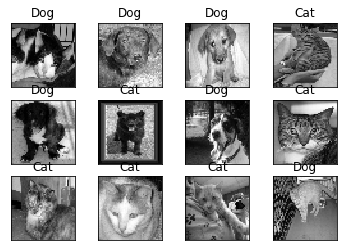

In [24]:
import matplotlib.pyplot as plt

test_data = np.load('test_data.npy')


fig = plt.figure()

for num,data in enumerate(test_data[:12]):

#cat: [1,0]
#dog: [0,1]

    img_num = data[1]
    img_data = data[0]
    
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE,1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label = 'Dog'
    else: str_label = 'Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()    
    
    